In [1]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

In [ ]:
modelo_tl = tf.keras.models.load_model('modelo_transfer_learning.keras')

with open('history_transfer_learning.pkl', 'rb') as file:
    historia_1 = pickle.load(file)

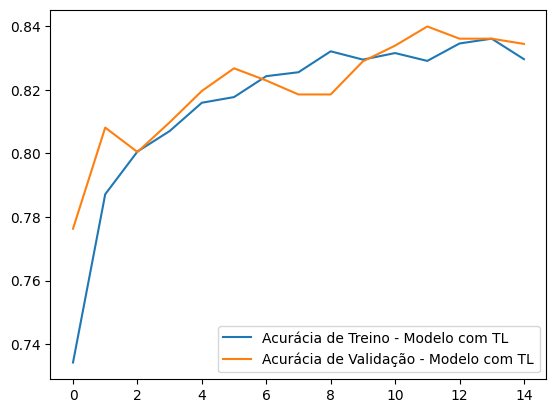

In [4]:
plt.plot(historia_1['accuracy'], label='Acurácia de Treino - Modelo com TL')
plt.plot(historia_1['val_accuracy'], label='Acurácia de Validação - Modelo com TL')
plt.legend()
plt.show()